Problem: Mountain Project is a website that hosts user-submitted guides on outdoor climbing routes. Each route has a general description, a description of the safety gear involved, and a rating of quality, among other data. 

We'll use logistic regression to predict a positive or negative route quality from these data. Predicting a binary like this is what logistic regression is good at, and the simplicity of the model will allow for rapid prototyping and adjustment of feature/selection or processing. There's enough data that this could be difficult, so having a simple model is beneficial in this aspect.

---

Patricia Degner wrote and ran a data scraper for mountainproject.com, collecting the information for every route on the website into a dataset on Kaggle: https://www.kaggle.com/pdegner/mountain-project-rotues-and-forums?select=mp_routes.csv


---


Let's clean the dataset. First, we'll print the head of the dataset to examine its format:

In [264]:
import math
import numpy as np
import pandas as pd

#Initialize the pandas DataFrame
df = pd.read_csv('/content/drive/Othercomputers/My Computer/RPI/21Fall/ProjectsMLAI/HW0/routes-full.csv')
df.head()

,Unnamed: 0,Route,Location,URL,Avg Stars,Route Type,Rating,Pitches,Length,Area Latitude,Area Longitude,desc,protection,num_votes
0,0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,https://www.mountainproject.com/route/11014983...,2.9,Sport,5.10b/c,4,350.0,25.95044,-100.47755,This is a really great route~ with awesome exp...,12 draws + 60m Rope Take 22 draws if you wan...,22
1,1,Agave Nectar,Sugar Shack > Cougar Canyon (Creek) - CONSTRUC...,https://www.mountainproject.com/route/11091386...,2.0,Sport,5.10b/c,1,NaN,51.09642,-115.31767,from tabvar: Cool fins to roof~ thin holds...,4 bolts to anchor,1
2,2,Ant & Bee do Yoga,The Hen House > Kamloops > British Columbia > ...,https://www.mountainproject.com/route/11240652...,2.7,Trad,5.10b/c,1,NaN,50.57212,-120.13874,A safe mixed route with a bit of run out up to...,"mixed~ gear to 4""",3
3,3,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,https://www.mountainproject.com/route/11608640...,2.0,Sport,5.10b/c,1,80.0,26.01097,-111.34166,Start on a slab under a left leaning arched ro...,bolts,1
4,4,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,https://www.mountainproject.com/route/11445772...,3.0,Sport,5.10b/c,1,60.0,49.71393,-123.09943,Fun technical climbing. Tricky right off the bat.,bolts,3


Mountain Project is an aggregation of information for many different kinds of climbing. Each have their own unique features, and as such, it is difficult to compare between each. As an example, 'Alpine' climbing would include mountaineering, such as climbing a glacier-covered mountain, while 'Bouldering' involves climbing short sections of rock or boulders with no ropes. These are vastly different activities, with different terminology, gear, communities, and skillsets.

We'll focus specifically towards rock climbing with ropes, which includes three categories: 'Sport', 'TR', and 'Trad'. These are the primary focus of the website, and each are similar enough that they can be compared. They also use roughly the same terminology. Let's remove any routes that involve climbing from a different category:

In [265]:
df = df[df['Route Type'].str.contains("Aid|Alpine|Boulder|Ice|Mixed|Snow")==False] #this leaves us with just routes involving Sport, TR, and/or Trad climbing
df.groupby(['Route Type']).groups.keys()
df.shape

(111237, 14)

After removing routes of the wrong type, we can see ~111,000 entries remaining. This should be plenty of data to train the model.

From personal experience, a route's location has no bearing on its quality. Four star routes can be directly adjacent to one star routes on the rock, since the quality has to do with the exact holds and safety gear placements. [TODO]


---

Let's check for null values in each column:

In [227]:
df.isnull().any()

Unnamed: 0        False
Route              True
Location          False
URL               False
Avg Stars         False
Route Type        False
Rating            False
Pitches           False
Length             True
Area Latitude     False
Area Longitude    False
desc               True
protection         True
num_votes         False
dtype: bool

The columns that have at least one NaN value are 'Route', 'Length', 'desc', and 'protection'. Let's check each to see the extent of the problem.

We start with 'Route', which is the name of the route:

In [228]:
df[df['Route'].isna()]

,Unnamed: 0,Route,Location,URL,Avg Stars,Route Type,Rating,Pitches,Length,Area Latitude,Area Longitude,desc,protection,num_votes
66842,66842,NaN,Caliza > El Chorro > Andalucia > Spain > Europ...,https://www.mountainproject.com/route/108774872,2.0,Sport,5.10d,1,NaN,36.91029,-4.76719,High first bolt on balancy moves~ then delicat...,6 quickdraws to single ring,2


There's just one example. It won't be a problem to exclude from the dataset when there are ~111,000 others to train with. 

Let's exclude it and drop any NaN values in 'Length', too:



In [229]:
df = df.drop(index=66842)
df = df[df['Length'].notna()]
df.shape

(96600, 14)

We now have ~96,000 examples, which should still be more than enough data.

Let's look at the largest and smallest 'Length' values to see if there are any anomalies.

We start with smallest:

In [181]:
df.nsmallest(260, 'Length')

,Unnamed: 0,Route,Location,URL,Avg Stars,Route Type,Rating,Pitches,Length,Area Latitude,Area Longitude,desc,protection,num_votes
11440,11440,Corner Unit,Backside Crags > The Papoose > Shannon Falls >...,https://www.mountainproject.com/route/11730457...,2.4,Trad,5.8,1,-125.0,49.66778,-123.16409,The right-most climb on the wall. Start up the...,"6 bolts + SR to 2""~ 70m rope",5
51569,51569,Side of Hashbrowns,Scramblers Wall > 03-First Pullout (Calico I) ...,https://www.mountainproject.com/route/11185754...,1.0,"Trad, TR",5.6,1,-90.0,36.14976,-115.43132,This route runs though a swath or cracks towar...,Standard rack ~ Two bolt anchor at top.,1
51570,51570,Side of Mixed Fruit,Scramblers Wall > 03-First Pullout (Calico I) ...,https://www.mountainproject.com/route/11185767...,1.0,"Trad, TR",5.6,1,-90.0,36.14976,-115.43132,This route follows scattered and somewhat disc...,Standard rack ~ 2 bolt anchor at top.,1
51395,51395,All American Breakfast,Scramblers Wall > 03-First Pullout (Calico I) ...,https://www.mountainproject.com/route/11185753...,1.0,"Trad, TR",5.5,1,-85.0,36.14976,-115.43132,"A ""stiff"" beginning gives way to much more mil...",Standard Rack to a #3 ~ Two bolt anchor at the...,1
95307,95307,Bookhouse Boys,(u) Northeast Buttress > Suicide Rock > Tahqui...,https://www.mountainproject.com/route/11448008...,2.0,"Trad, TR",5.11d,1,-30.0,33.77158,-116.69558,Climb the flared finger crack on the right sid...,Small cams and nuts,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75664,75664,Sandy Corner,Great Northern Slab > Lower Town Wall > Index ...,https://www.mountainproject.com/route/11636123...,1.9,Trad,5.10d,1,15.0,47.81842,-121.57221,Short stemming corner used as an alternate sta...,A few small nuts,8
76635,76635,Snakes and ladders,The. Old sawmill slabs > Central Idaho > Idaho,https://www.mountainproject.com/route/11219083...,2.0,Trad,5.7,1,15.0,44.26307,-114.44015,First route climbed at slabs~ nice outing up a...,A single bolt belay at base to stop your belay...,5
77504,77504,Fezzik,Castle > The Badlands > Central Oregon > Oregon,https://www.mountainproject.com/route/10735833...,2.0,Trad,5.6,1,15.0,43.98890,-121.03860,Plenty of features to choose from following th...,no bolts of anchor~ bring a pad.,2
77568,77568,African Swallow,Castle > The Badlands > Central Oregon > Oregon,https://www.mountainproject.com/route/10735824...,1.5,Trad,5.7,1,15.0,43.98890,-121.03860,Steep~ but enough pockets and a vertical crack...,no bolts or anchor. bring a pad.,2


Many of these routes with the smallest lengths appear to be user error. Some, like 'Paathala' (https://www.mountainproject.com/route/114063791/paathala), have attached images that show the route is much longer than the presented 1ft length. It is also impossible to have routes with a negative length. 

Some routes' climbing styles appear to be mislabeled. As an example, the route 'Cwank 2' (https://www.mountainproject.com/route/116197812/cwank-2) only involves the protection of a pad. This would be a foam pad placed on the ground to break a fall, with no ropes. Only using this kind of protection is just found in bouldering, while the label of the route is 'Trad'.

Unfortunately, there is no clear line that separates a route between bouldering and roped climbing. Often, it comes down to a climbers' limits: at what height do they not feel safe climbing without a rope? This can also vary by location, sometimes there exists no spot to place a pad at the base of the wall to break a fall, and so a rope is necessary even at short heights. This makes it very difficult to parse mislabelings in any way but with a manual judgement for each. Doing so among 96,000 examples would be impractical.

Generally, indoor bouldering does not exceed 15 feet. For reference, the Olympic bouldering wall was 4.5m (~14.75ft). After all, gravity is identical for everyone, no matter how strong the climber. Outdoor boulders may go much higher, in a form of the sport called "highball bouldering", though many argue this loses the spirit of bouldering and again, there is no clear line separating a highball boulder from a standard boulder. 

We'll set the lower bound for routes at 15ft to help mitigate mislabeling. Though it is somewhat arbitrary, a manual judgement on each route is impractical, especially since many entries do not include pictures, and even pictures themselves can be misleading. There are roughly 300 routes with length <= 15ft, an insignificant amount in comparison to the ~96,000 routes remaining.

Let's drop any entries with a length <= 15ft and explore the upper bound:

'desc' and 'protection' are each descriptions. If either of these contains a NaN value, we can replace it with an empty description:

In [182]:
df = df[df['Length'] > 15.0000001]
df.nlargest(60, 'Length')

,Unnamed: 0,Route,Location,URL,Avg Stars,Route Type,Rating,Pitches,Length,Area Latitude,Area Longitude,desc,protection,num_votes
65350,65350,Rumbly in My Tumbly,Rumbly Wall > Tumblestone > Tyler Peak Crags >...,https://www.mountainproject.com/route/11176697...,0.0,Sport,5.6 R,3,1209575.0,47.88823,-123.13858,A 70m or longer rope is required to reach the ...,QDs,1
31036,31036,Kocan,Kocan Sektor > Kemaliye > Turkey > Asia > Inte...,https://www.mountainproject.com/route/10889314...,3.0,Sport,5.10c,2,130100.0,39.24330,38.48791,The only multipitch route in the Kocan Sektor,First pitch 12 bolts~ second pitch 10 bolts,1
90438,90438,Scene of the Climb,e. The Mac Wall (Something Interesting) > The ...,https://www.mountainproject.com/route/10613810...,1.7,Trad,5.11a PG13,2,80160.0,41.73936,-74.18421,P1 is actually very nice~ but it is often wet ...,Standard Gunks rack + a screamer for the P1 cr...,3
85046,85046,Melting Into Madness,The Melting Mud Wall > East Hellgate > Hellgat...,https://www.mountainproject.com/route/10595868...,3.0,Sport,5.10+,1,80110.0,40.58991,-111.64385,A really fun .10 with lots of really big jugs ...,10 or 20 (or 21?) draws with some being long r...,100
35980,35980,The Rich Bechler Memorial,"FKT, Fastest Known Times > Linkups, Contrivanc...",https://www.mountainproject.com/route/11373829...,4.0,Trad,3rd,1,76576.0,43.41361,-89.73150,Named after the President of the DLFA~ and end...,If you don't carry water~ you can find it at t...,1
54515,54515,Le Bec de l'Aigle,Le Bec de L'Aigle > Southern Alps > France > E...,https://www.mountainproject.com/route/11354042...,2.0,Sport,5.10a,1,70120.0,44.42740,5.78619,The namesake route of the crag~ Le Bec de l'Ai...,Bolted sports route with fixed anchors.,1
66334,66334,La fidélité,Le Bec de L'Aigle > Southern Alps > France > E...,https://www.mountainproject.com/route/11354046...,2.0,Sport,5.10c,1,70120.0,44.42740,5.78619,Thin slabbin' up fine limestone. La fidélit...,Bolted sport climb with fixed top anchor(s).,1
57795,57795,Are the Pies Fresh?,Long Wall > Northern Gorge > Red River Gorge >...,https://www.mountainproject.com/route/10591790...,3.1,Sport,5.12a,2,70110.0,37.84460,-83.66860,A good long route with a hard crux. One can ba...,13 bolts plus slings for the anchors.,8
35979,35979,FVBT-Full Value Bluff Tour,"FKT, Fastest Known Times > Linkups, Contrivanc...",https://www.mountainproject.com/route/11373355...,4.0,Trad,3rd,1,32736.0,43.41361,-89.73150,At just over 6 miles~ this is one of the most ...,Running shoes with possible micro spikes in wi...,2
37751,37751,Standard Mirakamba-Saddle-Summit Route,Mount Meru > Tanzania > Africa > International,https://www.mountainproject.com/route/11187543...,3.4,Trad,3rd PG13,1,14980.0,-3.23800,36.76210,This is the standard guided route to the summi...,None required,5


When thinking of rock climbing, typically vertical climbing comes to mind. But, rock climbing is not always vertical. A climber can traverse horizontally. Some of these longest routes are traverses. A few, though, are genuinely some of the world's longest vertical routes, such as those on El Capitan.

Others are mislabelings, such as the extreme example 'Rumbly in My Tumbly' (https://www.mountainproject.com/route/111766970/rumbly-in-my-tumbly), which has the description of requiring a "70m or longer rope" (~230 ft) while having a length of 1209575.0 ft. Another example is 'Southwest Ridge' (https://www.mountainproject.com/route/111499486/southwest-ridge), a hike up a mountain that involves a short section of trad climbing. The climbing itself is not 4000ft, that is mostly hiking.

Let's visualize the effects these outliers have on the data, by graphing mean 'Length' by 'Avg Star' rating:


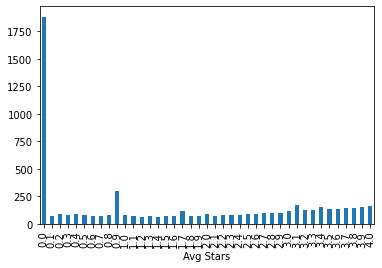

In [183]:
lengths = df.groupby(['Avg Stars'])['Length'].mean()
lengths.plot.bar()

It's clear these outliers must go.

"Freerider" (https://www.mountainproject.com/route/106261545/freerider), famous for being one of the longest vertical climbs in the world, will be the upper bound for climbing route lengths at 3300ft. While it is somewhat arbitrary, this cutoff will eliminate the most egrigous mislabelings that could affect exploratory data analysis and the model.

Any NaN descriptions, of the route ('desc') or the safety gear recommended for climbing it ('protection'), can be filled with an empty description in place of the NaN value.

We'll drop any routes with length >3300ft and perform this replacement:

In [184]:
df = df[df['Length'] < 3300.0000001]
df['desc'].fillna('', inplace=True)
df['protection'].fillna('', inplace=True)

The descriptions ('desc' and 'protection') both contain punctuation, which could hurt the models' performance. There's at least one case where it's warranted though, and that's in Yosemite Decimal System of climbing grades, used throughout the U.S. and globally. A grade is a subjective approximation of difficulty. The higher the grade, the harder the climb. Any rating that has a 5.X is a grade using the Yosemite Decimal System. The '.' in this context is an important character that we don't want to remove. 

Many descriptions also include examples like word1/word2 or word1-word2. So, any '/' or '-' will be replaced with a space. Any other case, the punctuation will be removed.

We'll also set every letter to lowercase, to minimize the number of unique character sequences in the dataset.

Let's clean the text:

In [185]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
allStopwords = stopwords.words('english')
climbingStopwords = ["start", "starts", "feet", "bolt", "belay", "draw", "standard", "pitch", "first", "line", "ledge", "way", "rack", "camalot", "slab", "roof", "face", "anchor", "route", "crux", "finish", "climb", "wall", "top", "two", "one", "bolts", "anchors", "gear", "chain"]
allStopwords.extend(climbingStopwords)

#note: this implementation is slow for such a large dataset.
def cleanText(text):
  #remove punctuation
  punctuation = (".", ",", "?", "!", ":", ";", "\\", "'", "\"", "~", "`", "_", "(", ")", "[", "]", "{", "}")
  cleanedText = "".join((text[i].lower() if (text[i] != "/" and text[i] != "-") else " ") for i in range(len(text)) if (text[i] not in punctuation) or (text[i] == "." and i != 0 and text[i-1] == "5") ) 

  #remove stopwords
  cleanedText = " ".join(word for word in cleanedText.split() if not word in allStopwords)

  return cleanedText

#clean df
df['desc'] = df['desc'].apply(cleanText)
df['protection'] = df['protection'].apply(cleanText)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,Route,Location,URL,Avg Stars,Route Type,Rating,Pitches,Length,Area Latitude,Area Longitude,desc,protection,num_votes
0,0,Access Denied,El Mirador > El Potrero Chico > Nuevo Leon > N...,https://www.mountainproject.com/route/11014983...,2.9,Sport,5.10b/c,4,350.0,25.95044,-100.47755,really great awesome exposure really cool summ...,12 draws + 60m rope take 22 draws want link pi...,22
3,3,Besame Fuerte,Pilon De Lolita > Loreto Area > Baja Californi...,https://www.mountainproject.com/route/11608640...,2.0,Sport,5.10b/c,1,80.0,26.01097,-111.34166,left leaning arched follow left arete left han...,,1
4,4,Big Momma's Rock,The Courtyard > Mamquam FSR > Squamish > Briti...,https://www.mountainproject.com/route/11445772...,3.0,Sport,5.10b/c,1,60.0,49.71393,-123.09943,fun technical climbing tricky right bat,,3
5,5,Big Splash,The Dark Pool > Powell River > British Columbi...,https://www.mountainproject.com/route/10744643...,3.0,Sport,5.10b/c,1,50.0,49.84860,-124.52870,potential 1 travers across canyon 2 swim bring...,free solo caution control fall water still hur...,1
6,6,Black Smear,The Slabs > Bear Mountain (AKA Bald Hill) > Ne...,https://www.mountainproject.com/route/10746663...,2.0,Trad,5.10b/c X,1,20.0,45.47227,-66.50856,upper slabs prominent black streak narrows tow...,none solo tr,1


In [186]:
df.isnull().any()

Unnamed: 0        False
Route             False
Location          False
URL               False
Avg Stars         False
Route Type        False
Rating            False
Pitches           False
Length            False
Area Latitude     False
Area Longitude    False
desc              False
protection        False
num_votes         False
dtype: bool

We can see that there are no NaN values remaining, and the data is cleaned.

---
---

Now that the data is cleaned, let's do some exploratory data analysis. We'll start by examining if there's a correlation between route length and avg stars.

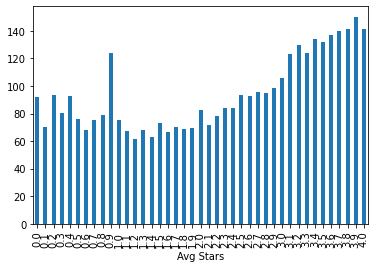

In [187]:
lengths = df.groupby(['Avg Stars'])['Length'].mean()
lengths.plot.bar()

It appears that there is a positive correlation between route length and quality. As such, we'll use it as a feature for the model.

I'm not sure why such a correlation exists, though.

---

Let's now examine any correlation between the number of votes a route receives and the avg star rating of those votes:

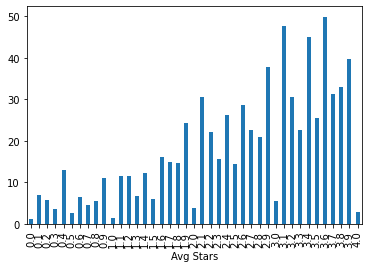

In [188]:
votes = df.groupby(['Avg Stars'])['num_votes'].mean()
votes.plot.bar()

There appears to be a strong positive correlation between the number of votes a route receives and its average star rating. Interestingly, even intervals of ratings (1.0, 2.5, 4.0, for example) are drastically low-performing outliers. 

I'd hypothesize that these outliers are due to averaging: it's uncommon for many people to agree on a quality rating, and ratings must be an integer between 0 and 4, so the chance that the collective average will be exactly on those intervals decreases as the number of votes increases. 

My hypothesis for the correlation is that people tend to want to climb high quality routes. The higher the quality, the more people climb it, who then agree that the route is high quality and rate it, so even more people climb it.

---

Next, let's look at the most common words in route descriptions, both of positive (>2.5 avg stars) and negative (<= 2.5 avg stars) quality. 

We'll start with a wordcloud of positive routes. Wordclouds are easy-to-read visualizations of word frequency in a block of text. Note that stopwords have been excluded from the descriptions in an earlier step.

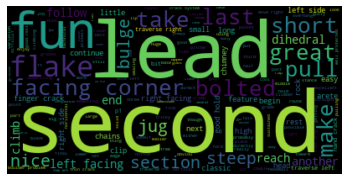

In [189]:
#code in this box derived from: https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6
# and https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

from wordcloud import WordCloud 
from matplotlib import pyplot as plt
# Create stopword list:
dfPositive = df[df['Avg Stars'] > 2.5]

textPositiveList = dfPositive['desc'].tolist()
textPositive = ' '.join(textPositiveList).lower()
wordcloudPositive = WordCloud().generate(textPositive)
plt.imshow(wordcloudPositive, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloudPositive.png')
plt.show()

Now the negative:

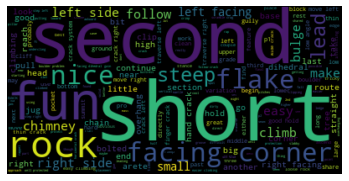

In [190]:
dfNegative = df[df['Avg Stars'] < 2.50000001]

textNegativeList = dfNegative['desc'].tolist()
textNegative = ' '.join(textNegativeList).lower()
wordcloudNegative = WordCloud().generate(textNegative)
plt.imshow(wordcloudNegative, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloudNegative.png')
plt.show()


This is promising! Though there is some overlap, certain words appear to be showing at different frequencies between the two categories.

Interestingly, 'fun' shows up frequently in both.

---

Let's build wordclouds of protection descriptions now:

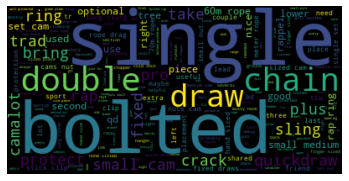

In [191]:
protextionPositiveList = dfPositive['protection'].tolist()
protextionPositive = ' '.join(protextionPositiveList).lower()
wordcloudPositiveP = WordCloud().generate(protextionPositive)
plt.imshow(wordcloudPositiveP, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloudPositiveP.png')
plt.show()

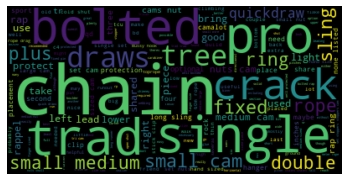

In [192]:
protextionNegativeList = dfNegative['protection'].tolist()
protextionNegative = ' '.join(protextionNegativeList).lower()
wordcloudNegativeP = WordCloud().generate(protextionNegative)
plt.imshow(wordcloudNegativeP, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloudNegativeP.png')
plt.show()

Similar results here, though the categories seem to have a more extreme difference than was present in 'desc'.

We'll use both descriptions as features in the model.

---

What other data is there?


In [266]:
df.columns.values.tolist()

['Unnamed: 0',
 'Route',
 'Location',
 'URL',
 'Avg Stars',
 'Route Type',
 'Rating',
 'Pitches',
 'Length',
 'Area Latitude',
 'Area Longitude',
 'desc',
 'protection',
 'num_votes']

There exists more data than the descriptions, route length, and number of votes. I don't think this data will be a useful predictor of route quality, though. 

A route's name ('Route') is set by whoever first climbed it. They're all over the place, and are named what they are for any reason. It'd be very difficult to establish a statistical correlation with them.

The URL is just the URL of the entry on the original website.

'Rating', the grade of the route, would be too difficult to parse. Different regions have different rating systems, which don't always scale appropriately, making conversions difficult.

'Pitches' counts the number of anchor points along the wall. Ropes are only so long, so climbers ascend up a 'pitch', gather the rope behind them, then ascend the next pitch. Doing so allows for much longer climbs than would otherwise be possible. Pitches vary widely in length themselves, so overall length is a much better metric.

'Unnamed: 0' seems to be indices for the entries in the dataset.

That leaves 'Location', 'Area Latitude', and 'Area Longitude'. In short, location has no impact on the quality of a route. It's not uncommon to see highly rated routes directly adjacent to poorly rated ones on the wall.

---
---

With exploratory data analysis complete, let's get the cleaned data into the testing and training sets.

We'll first split our dataframe into a training set and testing set at an approximate 90%/10% ratio. We'll also concatenate the 'desc' and 'protection' columns to make a complete description. For quality labels, we'll make a new column. Values in this column will be -1 if the avg star rating is <=2.5, 1 otherwise. This will serve as our labels for examples. 

These datasets will only have the columns containing features used in the model and the labels for each.

In [215]:
#form new, feature-friendly columns
df['complete_desc'] = df['desc'] + " " + df['protection'] #concatenate descriptions
df['quality'] = np.where(df['Avg Stars'] <= 2.50000001, -1, 1)

#trim dataset to only feature-friendly columns
dfTrimmed = df[['complete_desc', 'Length', 'num_votes', 'quality']]
dfTrimmed['randoms'] = np.random.default_rng(len(dfTrimmed.index)).random(len(dfTrimmed.index))

#split datasets
trainSet = dfTrimmed[dfTrimmed['randoms'] <= 0.90]
testSet = dfTrimmed[dfTrimmed['randoms'] > 0.90]
print("# of training set examples: " + str(len(trainSet.index)))
print("# of test set examples:     " + str(len(testSet.index)))

# of training set examples: 86753
# of test set examples:     9529


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


From these, we form a 2d tensor of features. First, we perform a count vectorization on the complete description, with an arbitrary feature limit of 1000. Though the full feature count could be used (which would include a feature for each character sequence present in the full descriptions), it was shown in testing to not impact results of the model, just runtimes.

We'll also initialize our weights and biases.

In [216]:
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer

numFeatures = 1000 #going beyond this seems to have little benefit besides longer computation times

#vectorize the complete description
vectorizer = CountVectorizer(max_features=(numFeatures-2))
xTrain = vectorizer.fit_transform(trainSet['complete_desc']).todense()

#create the tensor
xTrain = tf.convert_to_tensor(xTrain, dtype=tf.float32)

#add length and num_votes to each example
trainLengths = tf.convert_to_tensor(trainSet['Length'].tolist(), dtype=tf.float32)
trainLengths = tf.reshape(trainLengths, (trainLengths.shape[0], 1))
trainVotes = tf.convert_to_tensor(trainSet['num_votes'].tolist(), dtype=tf.float32)
trainVotes = tf.reshape(trainVotes, (trainVotes.shape[0], 1))
xTrain = tf.concat([xTrain, trainLengths], 1)
xTrain = tf.concat([xTrain, trainVotes], 1)

xTrain = xTrain * 0.001 #this smooths the data out, making for better gradient travel

#create label tensor
yTrain = tf.convert_to_tensor(trainSet['quality'].tolist(), dtype=tf.int32)

Let's establish some useful functions for logistic regression and gradient descent:

In [209]:
def sigmoid(x):
  return (1/(1+ np.exp(-x)))

#label is either -1 or 1
def loss(label, predicted):
  return -(label*np.log(predicted) + (1 - label)*np.log(1-predicted))

#labels is an mx1 tensor, predictions a list (these datatypes are convenient)
def cost(labels, predictions):
  numLabels = len(predictions)
  sumLoss = 0
  for i in range(numLabels):
    sumLoss += loss(labels[i].numpy(), predictions[i])
  return ((1/numLabels)*sumLoss)

def cost(losses):
  return np.mean(losses)

#input is an nx1 tensor, Xi
#weights is an nx1 tensor, W
#label is a scalar 1D tensor, yi
#this function was derived from pg. 62 of class textbook Neural Networks and Deep Learning (Charu C. Aggarwal)
#returns a vector of derivatives (loss with respect to weights)
def dloss_dweights(input, label, weights):
  return (label*input) / (1 + tf.exp(label * tf.tensordot(weights, input, 1)))

#input is an nx1 tensor, Xi
#weights is an nx1 tensor, W
#label and predicted are scalars, yi and yi_hat
def newWeights(weights, input, label, predicted, gradient):
  L2Regularizer = tf.reduce_mean((weights**2), 0)
  return weights*(1 - L2Regularizer*learningRate) + learningRate*gradient*loss(label, predicted)) #note: this applies an L2 regularization to help avoid exponential divergence

#input is an nx1 tensor, Xi
#bias is a scalar, b
#label is a scalar, yi
#returns a scalar (loss with respect to bias)
def dloss_dbias(label, predicted):
  return (label - predicted)

#input is an nx1 tensor, Xi
#bias is a scalar, b
#label and predicted are scalars, yi and yi_hat
def newBias(bias, input, label, predicted, gradient):
  return bias*(1-learningRate) - learningRate*gradient*loss(label, predicted))

Now let's write the training loop. This implements stochastic gradient descent, applying learning at every step.

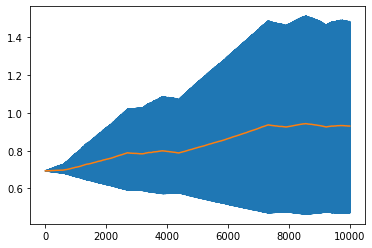

In [239]:
weights = tf.zeros([numFeatures])
bias = tf.zeros([1])

#these track the loss and cost over time to produce the graphs
stochasticLosses = []
stochasticCosts = []

learningRate = 0.0001 #this is a very low learning rate, but higher rates make the model even more unstable
epochs = 10000

for epoch in range(epochs):
  #establish variables for this epoch
  xi = xTrain[epoch]
  yi = yTrain[epoch].numpy() #call to numpy on a scalar returns an int/float/etc
  prediction = sigmoid((tf.tensordot(xi, weights, 1) + bias).numpy()[0])

  #record error data
  stochasticLosses.append(loss(yi, prediction))
  stochasticCosts.append(cost(stochasticLosses)) #to speed up processing, cost can be calculated at a set interval instead of at each step

  #update weights and biases
  weightsGradients = dloss_dweights(xi, yi, weights)
  biasGradient = dloss_dbias(yi, prediction)
  weights = newWeights(weights, xi, yi, prediction, weightsGradients)
  bias = newBias(bias, xi, yi, prediction, biasGradient)

plt.plot(stochasticLosses)
plt.plot(stochasticCosts)

Now we implement mini-batch gradient descent, applying learning after each successive 'batch' of steps.

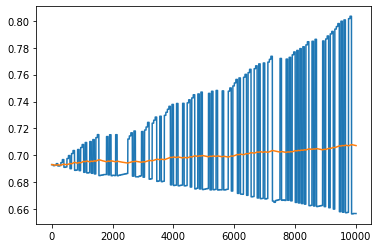

In [223]:
#I found the paper we read in class to be confusing, this article had a clearer explanation of mini-batch gradient descent: https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a
#The process described there is what I'll be implementing, it appears to be the same idea.

weights = tf.zeros([numFeatures])
bias = tf.zeros([1])

#these track the loss and cost over time to produce the graphs
batchLosses = []
batchCosts = []

learningRate = 0.001
epochs = 200
batchSize = 50

for epoch in range(epochs):
  weightsGradientsSum = 0
  biasGradientSum = 0

  for b in range(batchSize):
    #establish variables for this epoch
    xi = xTrain[epoch]
    yi = yTrain[epoch].numpy() #call to numpy on a scalar returns an int/float/etc
    prediction = sigmoid((tf.tensordot(xi, weights, 1) + bias).numpy()[0])

    #record error data
    batchLosses.append(loss(yi, prediction))
    batchCosts.append(cost(batchLosses)) #to speed up processing, cost can be calculated at a set interval instead of at each step

    #record gradients for later training
    weightsGradientsSum += dloss_dweights(xi, yi, weights)
    biasGradientSum += dloss_dbias(yi, prediction)

  #update weights and biases using the average gradient over the batch
  weights = newWeights(weights, xi, yi, prediction, weightsGradientsSum/batchSize)
  bias = newBias(bias, xi, yi, prediction, biasGradientSum/batchSize)

plt.plot(batchLosses)
plt.plot(batchCosts)

Unfortunately, neither of these models appear to converge, or even descend the gradient, no matter the combination of hyperparameters. I've chosen the hyperparameters that appear to have the best performance of those I've tested. Since the model doesn't even converge on the training data, it's not worth trying on the testing data.

In short, I believe this model is faulty because I was too ambitious about the problem selection. It appeared as a simple sentiment analysis problem at first, but as I've worked through this project, the limitations and complexities of the dataset have shown themselves. 

Assuming the model is implemented correctly, I believe this poor performance is due to poor feature selection, availability, and/or processing. Between every description, even after the cleaning performed, there are over *40,000* unique words. Having this many words to process properly would take an incredible amount of data for the model to 'realize' which words have the strongest associations with positive or negative quality routes. I have run the stochastic gradient descent implementation through the entire training set (see image below), but if the model would converge eventually, those ~85,000 entries are not enough.

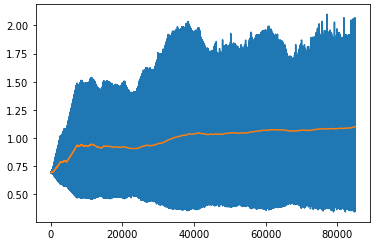

Building a better parser would help with this, but doing so is difficult. Mountain Project, while mostly consisting of English users, is a global website. Filtering just for English would be manageable, but climbing also involves technical notation and terminology. These also vary globally. With so many entries, typos are also inevitable.

As the saying goes: garbage in, garbage out.

Comparing the two implementations, mini-batch gradient descent appears to be more consistent due to its slower movement through the gradient. Individual examples don't sway the model as significantly, reducing variance. Still, it does not converge, nor does it move down the gradient.

I would hypothesize that in a correctly working model, mini-batch gradient descent would perform more poorly than stochastic. Updating at each step allows for every feature (word) to receive a more accurate weight. Individual words, in such a sparse featureset, may not arise in many examples. Mini-batch could miss the importance of those examples, reducing generalizability.

---

Even though the model is faulty, let's implement the optimizations. We begin with adding momentum to stochastic gradient descent. First, we define functions to generate momentum values at each step:

In [267]:
momentumTerm = 0.9

#input is an nx1 tensor, Xi
#prevMomentum is a float32
#label and predicted are scalars, yi and yi_hat
def newMomentum(prevMomentum, input, label, predicted, gradient):
  return prevMomentum*momentumTerm + learningRate*(gradient * loss(label, predicted))

Now we implement stochastic gradient descent with momentum:

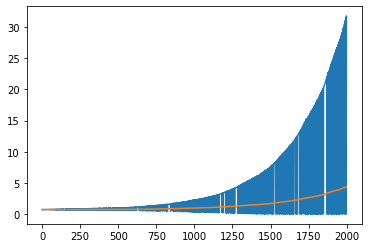

In [248]:
weights = tf.zeros([numFeatures])
bias = tf.zeros([1])

stochasticMLosses = []
stochasticMCosts = []

prevWeightsMomentum = 0
prevBiasMomentum = 0
learningRate = 0.0001
epochs = 2000

for epoch in range(epochs):
  #establish variables for this epoch
  xi = xTrain[epoch]
  yi = yTrain[epoch].numpy() #call to numpy on a scalar returns an int/float/etc
  prediction = sigmoid((tf.tensordot(xi, weights, 1) + bias).numpy()[0])

  #record error data
  stochasticMLosses.append(loss(yi, prediction))
  stochasticMCosts.append(cost(stochasticMLosses)) #to speed up processing, cost can be calculated at a set interval instead of at each step

  #calculate gradients
  weightsGradients = dloss_dweights(xi, yi, weights)
  biasGradient = dloss_dbias(yi, prediction)

  #calculate momenta
  prevWeightsMomentum = newMomentum(prevWeightsMomentum, xi, yi, prediction, weightsGradients)
  prevBiasMomentum = newMomentum(prevBiasMomentum, xi, yi, prediction, biasGradient)

  #update weights and biases
  L2Regularizer = tf.reduce_mean((weights**2), 0)
  weights = weights*(1 - learningRate*L2Regularizer) - prevWeightsMomentum
  bias = bias - prevBiasMomentum

plt.plot(stochasticMLosses)
plt.plot(stochasticMCosts)

Given that the model diverged in standard stochastic gradient descent, it's not surprising that adding momentum accelerates this divergence. Momentum is meant to accelerate the model. In this case, it happens to be accelerating the wrong way. 

I don't believe momentum is a good choice for real-world sentiment analysis, especially for sentiment analysis among such a large vocabulary. Sentiment can be difficult to pick out from the data. As such, smaller steps should be used to allow for more subtle trends to emerge. Momentum can easily pick up on biases in the dataset and amplify them. 

In [261]:
epsilon = 0.000000001

#input is an nx1 tensor, Xi
#weights is an nx1 tensor, W
#label and predicted are scalars, yi and yi_hat
def newWeightsADAGRAD(weights, input, label, predicted, gradient, weightsADAGRAD):
  #L2Regularizer = tf.reduce_mean((weights**2), 0)
  return weights - learningRate/tf.math.sqrt(weightsADAGRAD + epsilon) * gradient #note: this applies an L2 regularization to help avoid exponential divergence

#input is an nx1 tensor, Xi
#bias is a scalar, b
#label and predicted are scalars, yi and yi_hat
def newBiasADAGRAD(bias, input, label, predicted, gradient, biasADAGRAD):
  return bias - learningRate/np.sqrt(biasADAGRAD + epsilon) * gradient

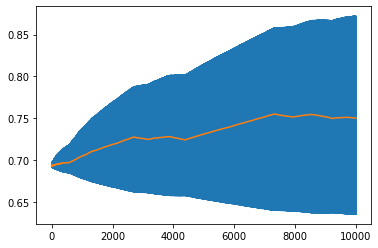

In [262]:
#source that helped me understand ADAGRAD, which this implementation is derived from: https://towardsdatascience.com/learning-parameters-part-5-65a2f3583f7d

weights = tf.zeros([numFeatures])
bias = tf.zeros([1])

stochasticAdaLosses = []
stochasticAdaCosts = []

learningRate = 0.001
weightsADAGRAD = tf.fill([numFeatures, 1], float(0.001))
biasADAGRAD = float(0.001)
epochs = 10000

for epoch in range(epochs):
  #establish variables for this epoch
  xi = xTrain[epoch]
  yi = yTrain[epoch].numpy() #call to numpy on a scalar returns an int/float/etc
  prediction = sigmoid((tf.tensordot(xi, weights, 1) + bias).numpy()[0])

  #record error data
  stochasticAdaLosses.append(loss(yi, prediction))
  stochasticAdaCosts.append(cost(stochasticAdaLosses)) #to speed up processing, cost can be calculated at a set interval instead of at each step

  #calculate gradients
  weightsGradients = dloss_dweights(xi, yi, weights)
  biasGradient = dloss_dbias(yi, prediction)

  #update learning rates (ADAGRAD)
  weightsADAGRAD = weightsADAGRAD + weightsGradients**2
  biasADAGRAD = biasADAGRAD + biasGradient**2

  #update weights and biases TODO
  weights = newWeightsADAGRAD(weights, xi, yi, prediction, weightsGradients, weightsADAGRAD)
  bias = newBiasADAGRAD(bias, xi, yi, prediction, biasGradient, biasADAGRAD)

plt.plot(stochasticAdaLosses)
plt.plot(stochasticAdaCosts)

These results are far better than those of momentum, and slightly better than standard stochastic gradient descent. 

ADAGRAD is known to be useful when working with sparse datasets, which this is. That's because ADAGRAD weights towards parameters that appear frequently faster, and those that appear infrequently, slower. Words that appear more frequently are more likely to be good sentiment indicators. Words that appear infrequently are more likely to be biased towards one sentiment classification, due to imbalanced data. ADAGRAD weights these cases more appropriately.

ADAGRAD is a great optimization algorithm for NLP tasks such as this one. If attempting another similar problem, I'd use it (or a further variant of it). Momentum would just be detrimental to a task like this, though.


---